# DATASET

In [15]:
import numpy as np
import tensorflow_datasets as tfds
import tqdm
from PIL import Image
from IPython import display

import mujoco,sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../package/')
sys.path.append('../package/helper/')
sys.path.append('../package/mujoco_usage/')

from mujoco_parser import *
from transformation import *
from slider import *
from utility import *
from utils import *

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo:[%s]"%(mujoco.__version__))

MuJoCo:[3.1.6]


In [16]:
dataset = DATASETS[42] # stanford_robocook_converted_externally_to_rlds
display_key = 'image_2'

ds, iterator = get_dataset(dataset, display_key=display_key)

FeaturesDict({
    'episode_metadata': FeaturesDict({
        'extrinsics_1': Tensor(shape=(4, 4), dtype=float32),
        'extrinsics_2': Tensor(shape=(4, 4), dtype=float32),
        'extrinsics_3': Tensor(shape=(4, 4), dtype=float32),
        'extrinsics_4': Tensor(shape=(4, 4), dtype=float32),
        'file_path': Text(shape=(), dtype=string),
    }),
    'steps': Dataset({
        'action': Tensor(shape=(7,), dtype=float32),
        'discount': Scalar(shape=(), dtype=float32),
        'is_first': bool,
        'is_last': bool,
        'is_terminal': bool,
        'language_embedding': Tensor(shape=(512,), dtype=float32),
        'language_instruction': Text(shape=(), dtype=string),
        'observation': FeaturesDict({
            'depth_1': Tensor(shape=(256, 256), dtype=float32),
            'depth_2': Tensor(shape=(256, 256), dtype=float32),
            'depth_3': Tensor(shape=(256, 256), dtype=float32),
            'depth_4': Tensor(shape=(256, 256), dtype=float32),
           

In [17]:
episode = next(iterator)
images = get_image_from_episode(episode, display_key=display_key)

import os
from PIL import Image
import numpy as np
os.environ["IMAGEIO_FFMPEG_EXE"] = "/opt/homebrew/bin/ffmpeg"

from moviepy import *

frames = [np.array(img.convert('RGB')) for img in images]
clip = ImageSequenceClip(frames, fps=3)
clip.write_videofile("output.mp4", codec='libx264', audio=False)

2025-01-27 17:55:05.296140: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:52: Filling up shuffle buffer (this may take a while): 1 of 10
2025-01-27 17:55:13.729094: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-01-27 17:55:13.775244: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


MoviePy - Building video output.mp4.
MoviePy - Writing video output.mp4



MoviePy - Done !
MoviePy - video ready output.mp4


In [18]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def arr2image(array):
    """
    Displays a NumPy array (h, w, c) as an image.
    """
    # Check the array shape and type
    if len(array.shape) != 3 or array.shape[2] not in [3, 4]:
        raise ValueError("Input array must have shape (h, w, c) with c=3 (RGB) or c=4 (RGBA).")
    
    # Display the image using matplotlib
    plt.imshow(array)
    plt.axis('off')  # Turn off axis
    plt.show()

# EPISODE

In [19]:
iter_steps = iter(episode['steps'])
states = [state['observation']['state'] for state in iter_steps] # Joint states

# ENV

In [27]:
xml_path = '../mujoco_menagerie/franka_emika_panda/scene_stanford_robocook.xml'
env = MuJoCoParserClass(name='Tabletop',rel_xml_path=xml_path,verbose=False)

# CONTROL

In [10]:
# Visualize environment with initial pose from trajectory
env.init_viewer()

joint_names = ['joint1','joint2','joint3','joint4','joint5','joint6','joint7']
q0 = np.deg2rad([0.0, 0.0, 0.0, -90.0, 0.0, 90.0, 0.0])

env.reset()
env.forward(q=q0, joint_names=joint_names)

while env.is_viewer_alive():
  if env.loop_every(tick_every=10):
    env.plot_T(
        T=env.get_T_body(body_name='link0'),
        axis_len=0.5,print_xyz=False)
    
    env.plot_body_T(body_name='tcp_link',axis_len=0.1,axis_width=0.005)
    env.plot_contact_info(
        r_arrow=0.005,h_arrow=0.1,rgba_contact=(1,0,0,0.5),plot_sphere=False)
    
    env.render()

env.close_viewer()

In [26]:
sliders = MultiSliderClass( # Slider for EE control
    n_slider      = 7,
    title         = 'Sliders for [%s] Control'%(env.name),
    window_width  = 450,
    window_height = 300,
    x_offset      = 0,
    y_offset      = 100,
    slider_width  = 300,
    label_texts   = ['X','Y','Z','Roll-deg','Pitch-deg','Yaw-deg','Gripper'],
    slider_mins   = [-1,-1,0,-180,-180,-180,0],
    slider_maxs   = [+1,+1,1.2,+180,+180,+180,255],
    slider_vals   = [0,0,0,0,0,0,0],
    resolutions   = [0.02,0.02,0.02,3.6,3.6,3.6,0.04], # range/50
    verbose       = False,
)

joint_names = env.joint_names

# Don't Know Why.....
# q0 = np.array([0, -1, 0, 1, 6, 1.7, 0])

q0 = np.zeros(len(joint_names), dtype=float)
#q0 = q_traj[60]

env.init_viewer(
    title       = 'Tabletop',
    transparent = False,
    azimuth     = 133,
    distance    = 3.5,
    elevation   = -42.4,
    lookat      = (-0.06,0.07,0.31),
)

env.reset() # reset
env.forward(q=q0,joint_names=joint_names) # initial position

p0 = env.get_p_body(body_name='tcp_link')
R0 = env.get_R_body(body_name='tcp_link')

# Loop
q_ik_init = q0.copy()
while env.is_viewer_alive():
    
    # Update
    sliders.update() # update slider
    xyzrpyg = sliders.get_slider_values()
    qpos,ik_err_stack,ik_info = solve_ik(
        env                = env,
        joint_names_for_ik = joint_names,
        body_name_trgt     = 'tcp_link',
        q_init             = q_ik_init,
        p_trgt             = xyzrpyg[:3]+p0,
        R_trgt             = rpy_deg2r(xyzrpyg[3:6])@R0,
        max_ik_tick        = 500,
        ik_stepsize        = 1.0,
        ik_eps             = 1e-2,
        ik_th              = np.radians(5.0),
        render             = False,
        verbose_warning    = False,
    )
    ik_err = np.abs(ik_err_stack).max() # IK error
    if ik_err < 1e-2: q_ik_init = qpos.copy()
    else: q_ik_init = q0.copy()
    
    env.step( # dynamic update
        ctrl        = qpos, #np.append(np.append(qpos,xyzrpyg[6]),xyzrpyg[6]),s
        joint_names = joint_names
    )
    
    # Render 
    if env.loop_every(tick_every=10):
        env.plot_T(
            T=env.get_T_body(body_name='base_link'),
            axis_len=0.5,print_xyz=False)
        env.plot_text(
            p=env.get_p_body(body_name='base_link')+np.array([0,0,0.5]),
            label = 'time:[%.2f]sec ik_err:[%.3f]'%(env.get_sim_time(),ik_err))
        env.plot_body_T(body_name='tcp_link',axis_len=0.1,axis_width=0.005)
        env.plot_contact_info(
            r_arrow=0.005,h_arrow=0.1,rgba_contact=(1,0,0,0.5),plot_sphere=False)
        plot_ik_info(env=env,ik_info=ik_info)
        
        env.render()

# Close
env.close_viewer()
sliders.close()
print ("Done.")

Done.


In [19]:
sliders = MultiSliderClass( # Slider for joint control
    n_slider      = 8,
    title         = 'Sliders for [%s] Control'%(env.name),
    window_width  = 450,
    window_height = 300,
    x_offset      = 0,
    y_offset      = 100,
    slider_width  = 300,
    label_texts   = ['Joint 1', 'Joint 2', 'Joint 3', 'Joint 4', 'Joint 5', 'Joint 6', 'Joint 7', 'Gripper'],
    slider_mins   = np.degrees(env.joint_ranges[:,0]).tolist() + [0], # Convert joint ranges from radians to degrees
    slider_maxs   = np.degrees(env.joint_ranges[:,1]).tolist() + [255],
    slider_vals   = [0, 0, 0, 0, 0, 0, 0, 0],
    resolutions   = [(max-min)/50 for min,max in zip(np.degrees(env.joint_ranges[:,0]).tolist() + [0], 
                                                    np.degrees(env.joint_ranges[:,1]).tolist() + [255])],
    verbose       = False,
)

joint_names = env.joint_names
q0 = np.array([0.0,             # Joint 1 
               1.1426,          # Joint 2
               -0.0002,         # Joint 3 
               1.1451,          # Joint 4
               -0.0001,         # Joint 5
               0.9371,          # Joint 6
               0.0000])         # Joint 7

#   q0 = np.zeros(len(joint_names), dtype=float)

env.init_viewer(
    title       = 'Tabletop',
    transparent = False,
    azimuth     = 133,
    distance    = 3.5,
    elevation   = -42.4,
    lookat      = (-0.06,0.07,0.31),
)
env.reset() # reset
env.forward(q=q0,joint_names=joint_names) # initial position

# Loop
while env.is_viewer_alive():
    
    # Update
    sliders.update() # update slider
    joint_values = sliders.get_slider_values()
    
    # Convert degrees to radians for joint angles
    qpos = np.radians(joint_values[:7])
    
    env.forward( # static update
        q           = qpos, # Last value is gripper
        joint_names = joint_names
    )
    
    # Render 
    if env.loop_every(tick_every=10):
        env.plot_T(
            T=env.get_T_body(body_name='base_link'),
            axis_len=0.5,print_xyz=False)
        env.plot_text(
            p=env.get_p_body(body_name='base_link')+np.array([0,0,0.5]),
            label = 'time:[%.2f]sec'%(env.get_sim_time()))
        env.plot_body_T(body_name='tcp_link',axis_len=0.1,axis_width=0.005)
        env.plot_contact_info(
            r_arrow=0.005,h_arrow=0.1,rgba_contact=(1,0,0,0.5),plot_sphere=False)
        
        env.render()

# Close
env.close_viewer()
sliders.close()
print ("Done.")

Done.


# Trajectory

### 1) genration

In [28]:
joint_names = ['joint1','joint2','joint3','joint4','joint5','joint6','joint7']

#q0 = np.zeros_like(joint_names, dtype=float)
q0 = np.deg2rad([0.0, 0.0, 0.0, -90.0, 0.0, 90.0, 0.0])

q_traj = []

q_ik_init = q0.copy()
for ik_target in states:

    qpos,ik_err_stack,ik_info = solve_ik(
        env                = env,
        joint_names_for_ik = joint_names,
        body_name_trgt     = 'tcp_link',
        q_init             = q_ik_init,
        p_trgt             = ik_target[:3],
        R_trgt             = rpy2r(ik_target[3:6]),
        max_ik_tick        = 500,
        ik_stepsize        = 1.0,
        ik_eps             = 1e-2,
        ik_th              = np.radians(5.0),
        render             = False,
        verbose_warning    = False,
    )

    ik_err = np.abs(ik_err_stack).max() # IK error
    if ik_err < 1e-2: q_ik_init = qpos.copy()
    else: q_ik_init = q0.copy()
    
    # print(ik_err, ik_target[:3], rot_target)
    q_traj.append(qpos)

### 2) Comparing

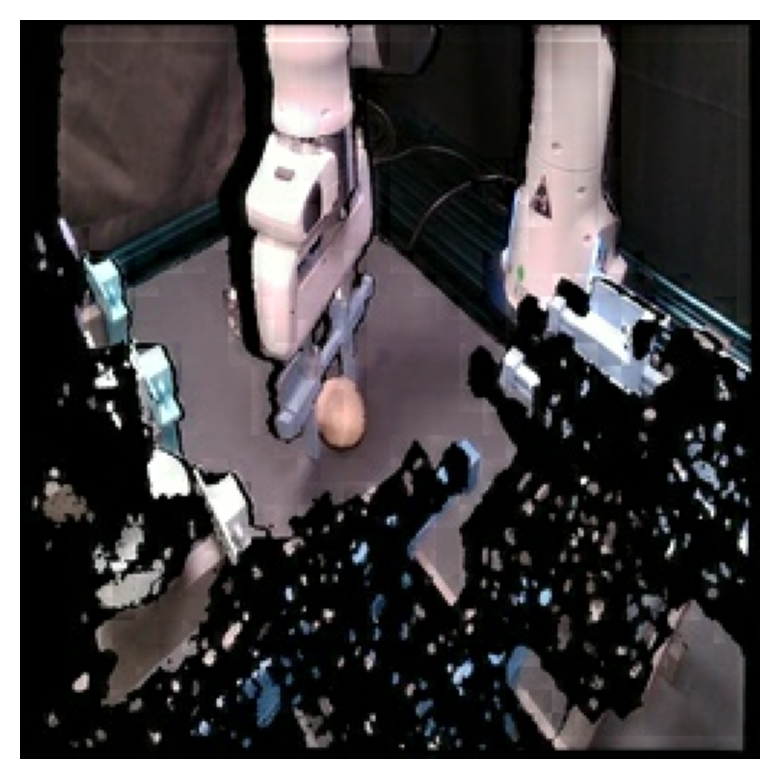

2025-01-27 17:48:25.180 python[35161:2225993] +[IMKClient subclass]: chose IMKClient_Modern
2025-01-27 17:48:25.180 python[35161:2225993] +[IMKInputSession subclass]: chose IMKInputSession_Modern
2025-01-27 17:49:45.412 python[35161:2225993] TSM AdjustCapsLockLEDForKeyTransitionHandling - _ISSetPhysicalKeyboardCapsLockLED Inhibit


Done.


In [8]:
# G -> B -> R

idx = 10
assert idx < len(frames)

sliders = MultiSliderClass( # Slider for EE control
    n_slider      = 7,
    title         = 'Sliders for [%s] Control'%(env.name),
    window_width  = 450,
    window_height = 300,
    x_offset      = 0,
    y_offset      = 100,
    slider_width  = 300,
    label_texts   = ['X','Y','Z','Roll-deg','Pitch-deg','Yaw-deg','Gripper'],
    slider_mins   = [-1,-1,0,-180,-180,-180,0],
    slider_maxs   = [+1,+1,1.2,+180,+180,+180,2],
    slider_vals   = [0,0,0,0,0,0,0],
    resolutions   = [0.02,0.02,0.02,3.6,3.6,3.6,0.04], # range/50
    verbose       = False,
)

joint_names = ['joint1','joint2','joint3','joint4','joint5','joint6','joint7']
env.reset(step=True)

q0 = q_traj[idx]
env.forward(q=q0,joint_names=joint_names) # initial position

p0 = env.get_p_body(body_name='tcp_link')
R0 = env.get_R_body(body_name='tcp_link')

env.init_viewer(
    title       = 'Tabletop',
    transparent = False,
    azimuth     = 133,
    distance    = 3.5,
    elevation   = -42.4,
    lookat      = (-0.06,0.07,0.31),
)

arr2image(frames[idx])

# Loop
q_ik_init = q0.copy()
while env.is_viewer_alive():
    
    # Update
    sliders.update() # update slider
    xyzrpyg = sliders.get_slider_values()
    qpos,ik_err_stack,ik_info = solve_ik(
        env                = env,
        joint_names_for_ik = joint_names,
        body_name_trgt     = 'tcp_link',
        q_init             = q_ik_init,
        p_trgt             = xyzrpyg[:3]+p0,
        R_trgt             = rpy_deg2r(xyzrpyg[3:6])@R0,
        max_ik_tick        = 500,
        ik_stepsize        = 1.0,
        ik_eps             = 1e-2,
        ik_th              = np.radians(5.0),
        render             = False,
        verbose_warning    = False,
    )
    
    ik_err = np.abs(ik_err_stack).max() # IK error
    if ik_err < 1e-2: q_ik_init = qpos.copy()
    else: q_ik_init = q0.copy()
    
    env.step( # dynamic update
        ctrl        = qpos,
        joint_names = joint_names
    )
    
    # Render 
    if env.loop_every(tick_every=10):
        env.plot_T(
            T=env.get_T_body(body_name='link0'),
            axis_len=0.5,print_xyz=False)
        env.plot_text(
            p=env.get_p_body(body_name='link0')+np.array([0,0,0.5]),
            label = 'time:[%.2f]sec ik_err:[%.3f]'%(env.get_sim_time(),ik_err))
        env.plot_body_T(body_name='tcp_link',axis_len=0.1,axis_width=0.005)
        env.plot_contact_info(
            r_arrow=0.005,h_arrow=0.1,rgba_contact=(1,0,0,0.5),plot_sphere=False)
        plot_ik_info(env=env,ik_info=ik_info)
        
        env.render()

# Close
env.close_viewer()
sliders.close()
print("Done.")

# Trajectory Reappearance

In [29]:
joint_names = ['joint1','joint2','joint3','joint4','joint5','joint6','joint7']
q0 = np.zeros_like(joint_names, dtype=float)

env.init_viewer()

env.reset() # reset
env.forward(q=q0,joint_names=joint_names) # initial position
    
# Loop
q_ik_init = q0.copy()
qpos = q_traj[0]
idx = 0

while env.is_viewer_alive():
    env.forward(q=qpos,joint_names=joint_names)

    # Render 
    if env.loop_every(HZ=0.5):
        if idx < len(q_traj)-1:
            idx += 1
        else: idx = 0

        qpos = q_traj[idx]

        env.plot_T(
            T=env.get_T_body(body_name='link0'),
            axis_len=0.5,print_xyz=False)
        env.plot_text(
            p=env.get_p_body(body_name='link0')+np.array([0,0,0.5]),
            label = 'tick:[%d]time:[%.2f]'%(idx, env.get_sim_time()))
        env.plot_body_T(body_name='tcp_link',axis_len=0.1,axis_width=0.005)
        
        env.render()

# Close
env.close_viewer()
print ("Done.")

Done.


: 

In [12]:
joint_names = env.joint_names
q0 = np.zeros_like(joint_names, dtype=float)

env.init_viewer()

env.reset() # reset
env.forward(q=q0,joint_names=joint_names) # initial position
    
# Loop
q_ik_init = q0.copy()
qpos = states[0][:7]
idx = 0

while env.is_viewer_alive():
    env.forward(q=qpos,joint_names=joint_names)

    # Render 
    if env.loop_every(HZ=0.5):

        if idx < len(states)-1:
            idx += 1
        else: idx = 0

        qpos = states[idx][:7]  # Use first 7 joints from joint_states

        env.plot_T(
            T=env.get_T_body(body_name='base'),
            axis_len=0.5,print_xyz=False)
        env.plot_text(
            p=env.get_p_body(body_name='base')+np.array([0,0,0.5]),
            label = 'tick:[%d]time:[%.2f]'%(idx, env.get_sim_time()))
        env.plot_body_T(body_name='tcp_link',axis_len=0.1,axis_width=0.005)
        
        env.render()

# Close
env.close_viewer()
print ("Done.")

[0.505702   0.0711333  0.38534033]
[0.505702   0.0711333  0.38534033]
[0.505702   0.0711333  0.38534033]
Done.


# Reverse Engineering

In [12]:
# current link gripper -> tcp_link rpy 0,0,0
# target link gripper -> target rpy

target = states[idx][3:6]
target = rpy2r(target)

base = env.get_R_body(body_name='link7')
current = env.get_R_body(body_name='tcp_link')

R = current.T@base
rpy = r2rpy(R)
# print(rpy)

R = base.T@target
rpy = r2rpy(R)
# print(rpy)
print(rpy2quat(rpy))

[ 0.00235569 -0.32037747 -0.94721001  0.01207949]


In [24]:
quat2rpy([0.00235569, -0.32037747, -0.94721001, 0.01207949])

array([-3.11719705,  0.00327733,  2.48932552])

In [25]:
rpy2quat([-3.11719705,  0.00327733,  2.48932552-np.pi/2])

array([ 0.01020722, -0.89631971, -0.44323754,  0.00687576])